# BEE 4750 Homework 5: Solid Waste Disposal

**Name**: Ruby Pascual

**ID**: 5193485

> **Due Date**
>
> Friday, 10/27/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

``` julia
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
```

``` julia
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
```

In [363]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using JuMP
using Cbc
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

  Activating project at `~/Downloads/hw05-Ruby554-main`


## Background

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided in the table below.

|    **Disposal Facility**     | **Capacity** (Mg/d) | **Fixed cost** (\$/d) | **Tipping Fee ** (\$/Mg) | **Recycling Cost** (\$/Mg) |
|:-------------:|:-------------:|:-------------:|:----------:|:--------------:|
|           Landfill           |         200         |         2000          |            50            |                            |
| Materials Recycling Facility |         350         |         1500          |            7             |    40 (per Mg recycled)    |
|   Waste-to-Energy Facility   |         210         |         2500          |            60            |                            |

Transportation costs are \$1.5/Mg-km, and the relative distances between
the cities and facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

|   **Component**   | **% of total mass** | **Combustion ash** (%) | **MRF Recycling rate** (%) |
|:---------------------:|:--------------:|:---------------:|:---------------:|
|    Food Wastes    |         15          |           8            |             0              |
| Paper & Cardboard |         40          |           7            |             55             |
|     Plastics      |          5          |           5            |             15             |
|     Textiles      |          3          |           10           |             10             |
|  Rubber, Leather  |          2          |           15           |             0              |
|       Wood        |          5          |           2            |             30             |
|    Yard Wastes    |         18          |           2            |             40             |
|       Glass       |          4          |          100           |             60             |
|      Ferrous      |          2          |          100           |             75             |
|     Aluminum      |          2          |          100           |             80             |
|    Other Metal    |          1          |          100           |             50             |
|   Miscellaneous   |          3          |           70           |             0              |

The information in the above table will help you determine the overall
recycling and ash fractions. Note that the recycling residuals, which
may be sent to either landfill or the WTE, have different ash content
than the ash content of the original MSW. You will need to determine
these fractions to construct your mass balance constraints.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

## Problems (Total: 40 Points)

### Problem 1 (22 points)

In this problem, you will develop an optimal disposal plan for the two
cities.

#### Problem 1.1 (3 points)

Based on the information above, calculate the overall recycling and ash
fractions for the waste produced by each city.

In [364]:
#First write down information above 

Disposal_Facility= ["Landfill","MRF","WTE"];
Capacity= [200, 350, 210]; # mg/day
Fixed_cost= [2000, 1500, 2500];  # $/day
Tipping_fee= [50, 7, 60]; # $/mg
Recycling_cost= [0, 40, 0]; # $/mg

Transport_cost= 1.5; # $/mg-km

Dist_TO= ["Landfill","MRF","WTE"];
D_1= [5, 30, 15];    # km
D_2= [15, 25, 10];    # km
D_3= [13, 45, 20];     # km 
D_Landfill= [0, 32, 18];    # km 
D_MRF= [32, 0, 15];  # km
D_WTE= [18, 15, 0];  # km 

Source = ["City 1", "City 2", "City 3"];
production_1 = [100, 90, 120]; # mg/day 

Component = ["Food Waste", "Paper & Cardboard", "Plastics", "Textiles", "Rubber & Leather", "Wood", "Yard Wastes", 
    "Glass", "Ferrous", "Aluminum", "Other Metal", "Miscellaneous"];
Total_Mass = [0.15, 0.40, 0.05, 0.03, 0.02, 0.05, 0.18, 0.04, 0.02, 0.02, 0.01, 0.03];
Combustion_Ash = [0.08, 0.07, 0.05, 0.10, 0.15, 0.02, 0.02, 1, 1, 1, 1, 0.70];
MRF_Recycling_Rate = [0, 0.55, 0.15, 0.10, 0, 0.30, 0.40, 0.60, 0.75, 0.80, 0.50, 0];

#Determine recycling and ash fractions

recycling_fraction= sum(Total_Mass .* MRF_Recycling_Rate);
ash_fraction = sum(Total_Mass .* Combustion_Ash);

println("The recycling fraction is : " , round(recycling_fraction, digits= 3))
println("The ash fraction is: ", round(ash_fraction, digits= 3))

The recycling fraction is : 0.378
The ash fraction is: 0.164


#### Problem 1.2 (2 points)

What are the decision variables for your optimization problem? Provide
notation and variable meaning.

My decision variables will be $W_{i,j}$ which is the waste transported from city (source) i to disposal j (mg/day). I will also have $R_{k,j}$ which is the residual waste transported from disposal k to disposal j (mg/day). Finally, there will be $Y_j$ which is the operational status (on/off) of disposal j (binary variable).

In [365]:
using JuMP
using Cbc
waste_model= Model(Cbc.Optimizer)
I= 1: length(Source);
J= 1: length(Disposal_Facility);

#Define variables; here the constraint for all variables being greater than 0 is accounted for 
@variable(waste_model, W[i in I, j in J] >= 0);
@variable(waste_model, R[k in J, j in J] >= 0);
@variable(waste_model, Y[j in J], Bin); 

#### Problem 1.3 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s).

The objective function is to minimize total costs. Total costs will account for 'transportation' of waste and 'disposal' (fixed costs and variable costs). In general, we will account for fixed costs, tipping fees, recycling costs, and transportation costs. 

Overall order of waste disposal is MRF--WTE --> LF; MRF can go to WTE or LF and WTE can only go to LF  

We have LF (Landfill) costs (fixing and tipping)- Disposal 1: 

$2000*Y_1+ 50*(W_{1,1}+ W_{2,1}+ W_{3,1}+ R_{2,1}+ R_{3,1})$          #50 = LF tipping fee, 2000= LF fixed cost 

We have MRF (Materials Recycling Facility) costs- Disposal 2 :

#7= MRF tipping fee, Recycling_fraction= 0.378, 40= Recyling_cost of MRF, 1500= fixed cost 

$1500*Y_2+ 7*(W_{1,2}+ W_{2,2}+W_{3,2})+ 0.378*(40)*(W_{1,2}+ W_{2,2}+W_{3,2})$    

We have WTE (Waste to Energy Facility) costs- Disposal 3:

$2500 *Y_3 + 60*(W_{1,3}+ W_{2,3}+W_{3,3}+ R_{2,3})$       # 60= WTE tipping fee, 2500= WTE fixed cost  

We have Transportation costs: 

$1.5[5*W_{1,1}+ 30*W_{1,2}+ 15*W_{1,3}+ 15*W_{2,1}+ 25*W_{2,2}+ 10* W_{2,3}+ 13*W_{3,1}+ 45*W_{3,2}+ 20*W_{3,3}+ 18*R_{3,1}+ 15*R_{2,3}+ 32*R_{2,1}]$     #1.5= transportation cost

In [366]:
#order is as follows W_{1,1} W_{1,2} W{1,3}; W{2,1} W{2,2} W{3,2}; ... 
@objective(waste_model, Min, sum([57.5 67.12 82.5; 72.5 59.62 75; 69.5 89.62 90] .* W)
    + sum([0 0 0; 98 0 82.5; 77 0 0] .* R) + sum([2000, 1500, 2500] .* Y))

57.5 W[1,1] + 72.5 W[2,1] + 69.5 W[3,1] + 67.12 W[1,2] + 59.62 W[2,2] + 89.62 W[3,2] + 82.5 W[1,3] + 75 W[2,3] + 90 W[3,3] + 98 R[2,1] + 77 R[3,1] + 82.5 R[2,3] + 2000 Y[1] + 1500 Y[2] + 2500 Y[3]

#### Problem 1.4 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

The constraints I have are as follows: 

1. City Waste Production Constraint 

For City 1:

$W_{1,1}+W_{1,2}+ W_{1,3} == 100$

For City 2:

$W_{2,1}+W_{2,2}+ W_{2,3} == 90$

For City 3:

$W_{3,1}+W_{3,2}+ W_{3,3} == 120$


2. Disposal Limit Constraints- Waste and recycling must stay within disposal facility's capacities:

For LF (1):

$W_{1,1}+W_{2,1}+ W_{3,1} + R_{2,1} + R_{3,1} <= 200$

For MRF (2): 

$W_{1,2}+ W_{2,2} + W_{3,2} <= 350$

For WTE (3):

$W_{1,3}+ W_{2,3}+ W_{3,3}+ R_{2,3} <= 210$

3. Residual Mass Balance Constraints- Any waste from WTE must equal ash produced: 

$R_{3,1}= ash.fraction*(W_{1,1}+W_{2,1}+ W_{3,1}+ R_{2,3})$

Also waste from MRF must equal nonrecycled waste that entered MRF:

$R_{2,3}+ R_{2,1}= (1- recyling.fraction)*(W_{1,2}+W_{2,2}+W_{3,2})$

4. Non-negativity Constraint- Last, define binary variable and ensure waste streams are non-negative

$$ Y_i = \begin{cases} 0 & \text{if } \sum_{i \in I}W_{ij}=0 \\ 1 & \text{if }\sum_{i \in I}W_{ij} > 0 \end{cases} $$

$Y_1 = 0$ if $W_{1,1}+ W_{2,1}+ W_{3,1}+ R_{2,1}+ R_{3,1} = 0$ Else $Y_1 =1$

$Y_2 = 0$ if $W_{2,1}+ W_{2,2}+ W_{3,2}= 0$ Else $Y_2 = 1$

$Y_3 = 1$

$W_{i,j} <= 0$

$R_{i,j} <= 0$






#### Problem 1.5 (3 points)

Implement your optimization problem in `JuMP`.

In [367]:
# 1. City Waste Production Constraint 
@constraint(waste_model, citi_1, W[1,1]+ W[1,2]+ W[1,3] == 100)
@constraint(waste_model, citi_2, W[2,1]+ W[2,2]+ W[2,3] == 90)
@constraint(waste_model, citi_3, W[3,1]+ W[3,2]+ W[3,3] == 120)

# 2. Disposal Limit Constraint 
#@constraint(waste_model, city_1[i in I], sum(W[i,:]) == production_1[i]);
@constraint(waste_model, L_F, W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1] <= 200);
@constraint(waste_model, MR_F, W[1,2] + W[2,2] + W[3,2] <= 350);
@constraint(waste_model, WT_E, W[1,3] + W[2,3] + W[3,3]+ R[2,3] <= 210);

# 2. Residual Mass Constraint 
@constraint(waste_model, residual_1, R[2,3] + R[2,1] == (1-recycling_fraction) .* (W[1,2] + W[2,2] + W[3,2]));
@constraint(waste_model, residual_2, R[3,1] == ash_fraction .* (W[1,1] + W[2,1] + W[3,1]) + R[2,3]);

#Translate Indicator constraints into JuMP
@constraint(waste_model, commit1, !Y[1] => {W[1,1] + W[2,1] + W[3,1] + R[2,1] + R[3,1]== 0});
@constraint(waste_model, commit2, !Y[2] => {W[1,2] + W[2,2] + W[3,2] == 0});
@constraint(waste_model, commit3, Y[3] == 1);

In [368]:
set_silent(waste_model)
optimize!(waste_model)

In [369]:
println("Waste Generated from each city is", value.(W))

Waste Generated from each city is2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:3
And data, a 3×3 Matrix{Float64}:
 100.0              0.0   0.0
   0.0              0.0  90.00000000000001
  71.8065458293961  0.0  48.19345417060391


In [370]:
println("Waste generated between residual facilities", value.(R))

Waste generated between residual facilities2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:3
And data, a 3×3 Matrix{Float64}:
  0.0               0.0  0.0
  0.0               0.0  0.0
 28.19345417060391  0.0  0.0


In [371]:
println("Status of Operations", value.(Y))

Status of Operations1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:3
And data, a 3-element Vector{Float64}:
 1.0
 0.0
 1.0


#### Problem 1.6 (2 points)

Find the optimal solution. Report the optimal objective value.

In [372]:
round(objective_value(waste_model), digits=2)

28498.86

#### Problem 1.7 (5 points)

Draw a diagram showing the flows of waste between the cities and the
facilities. Which facilities (if any) will not be used? Does this
solution make sense?

![4750 h.w 5.jpeg](<attachment:4750 h.w 5.jpeg>)
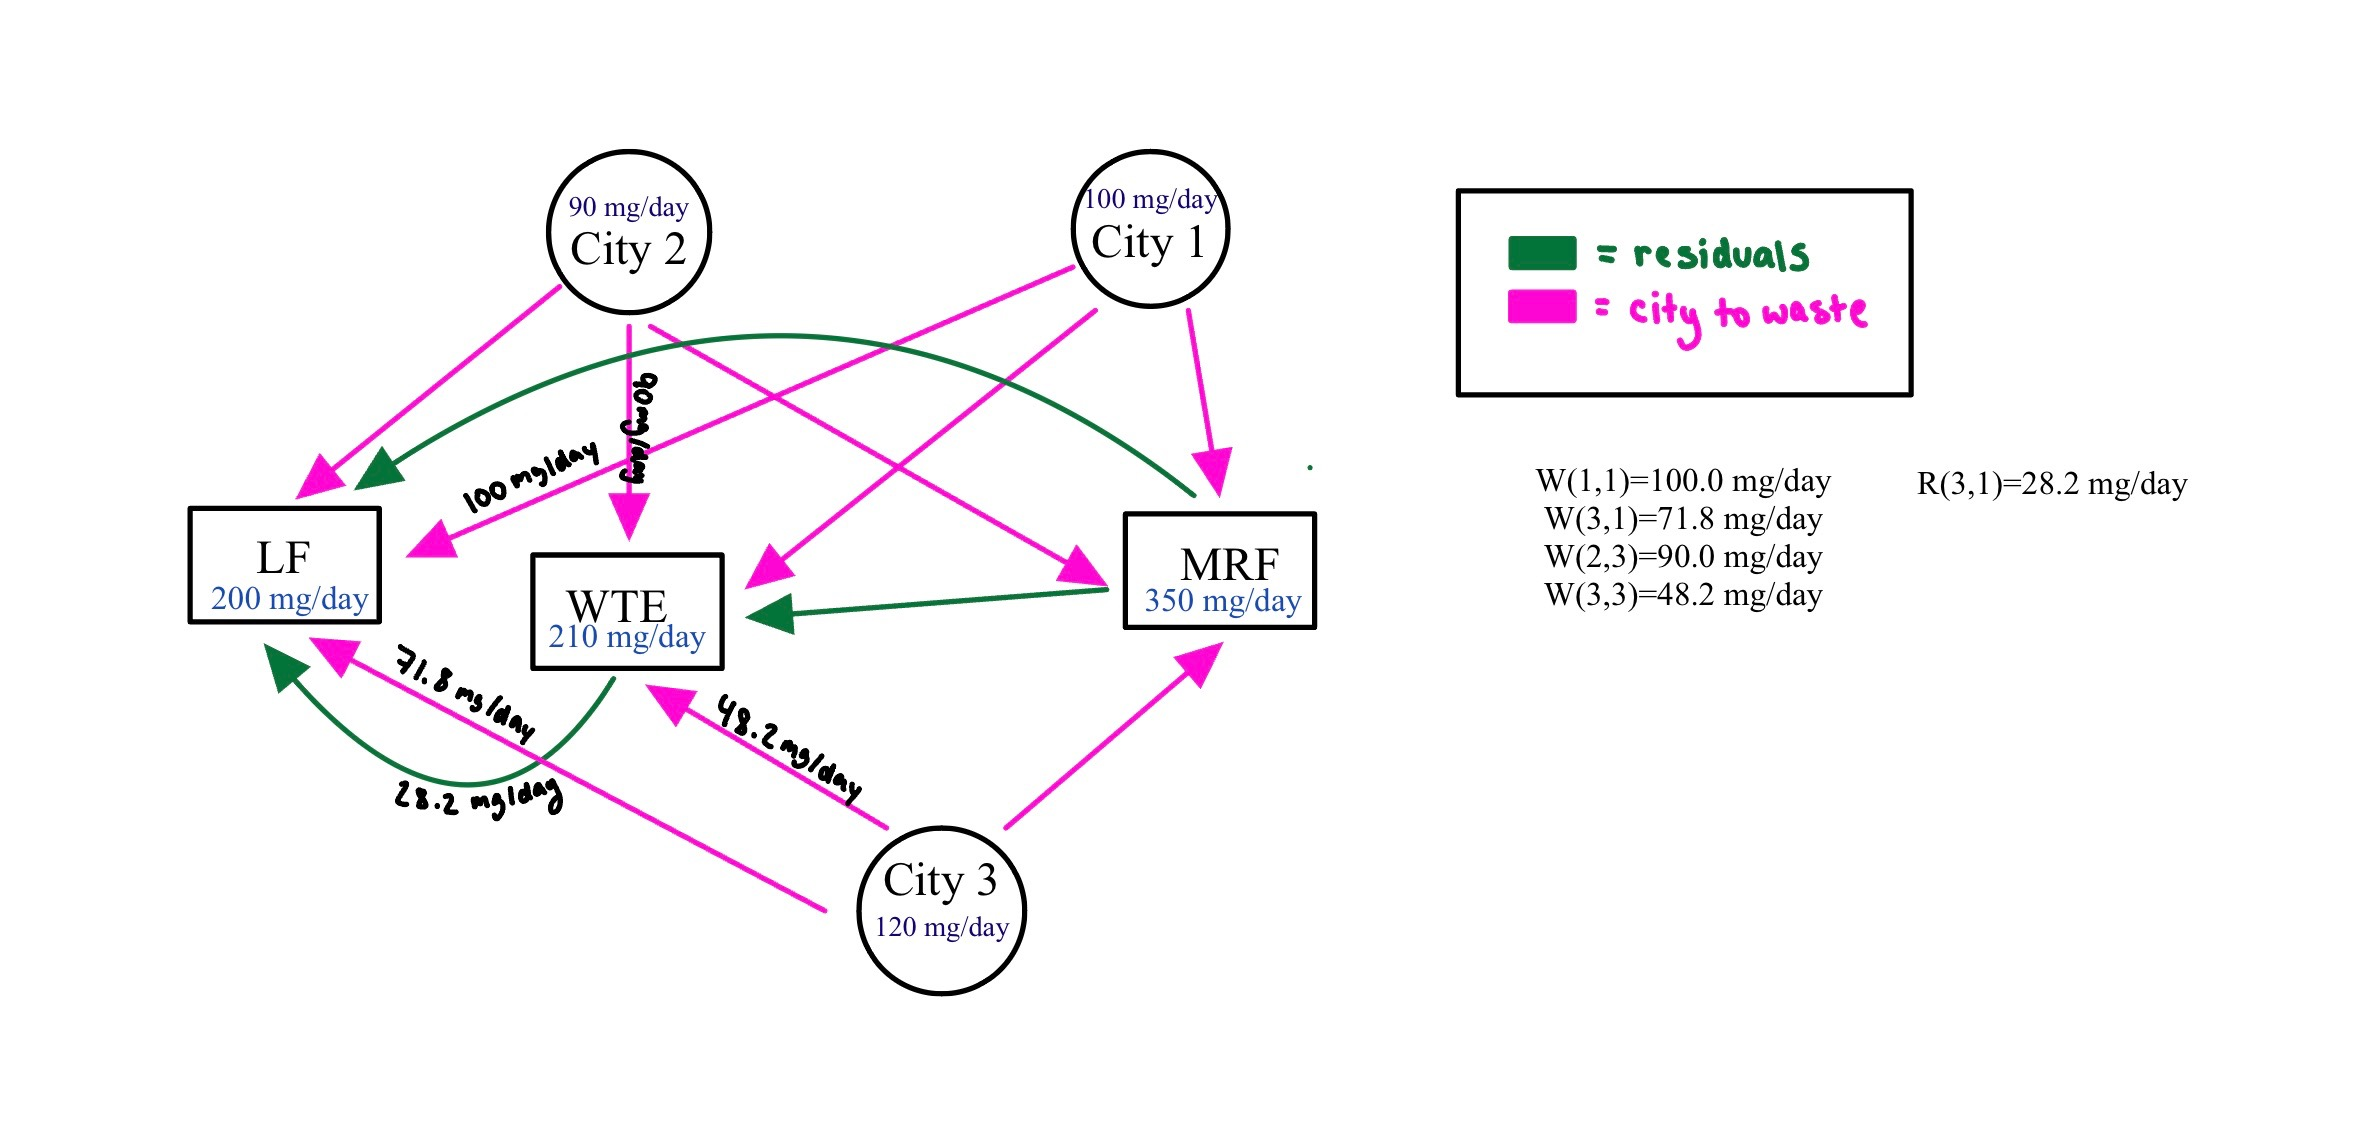

### Problem 2 (18 points)

It is projected that in the near future the state will introduce a
carbon tax that will increase the cost for transportation and for
disposal by incineration. It is estimated that the additional costs will
be:

-   tipping fee for the WTE facility will increase to\$75/Mg; and
-   transportation costs will increase to \$2/Mg-km.

In this context, the cities are considering adding another landfill and
want to know if this would be cost-effective compared to using the
current facilities with the carbon tax. This landfill would have a
maximum capacity of 100 Mg/day and would be located with the following
distances from the existing sites (excluding LF1):

| **City/Facility** | **Distance to LF2 (km)** |
|:-----------------:|:------------------------:|
|         1         |            45            |
|         2         |            35            |
|         3         |            15            |
|        MRF        |            35            |
|        WTE        |            50            |

The fixed cost of operating this facility would be the same as the first
landfill, but the tipping cost would be increased to \$60/Mg-day.

#### Problem 2.1 (5 points)

What changes are needed to your optimization program from Problem 1 for
this decision problem? Formulate any different variables, objectives,
and/or constraints.

In [373]:
using JuMP
using Cbc


New_Disposal_Facility= ["Landfill","MRF","WTE","Landfill 2"];

new_waste_model= Model(Cbc.Optimizer)
I= 1: length(Source);
J= 1: length(New_Disposal_Facility);

#Define variables; here the constraint for all variables being greater than 0 is accounted for 
@variable(new_waste_model, W_1[i in I, j in J] >= 0);
@variable(new_waste_model, R_1[k in J, j in J] >= 0);
@variable(new_waste_model, Y_1[j in J], Bin); 

The objective function is to minimize total costs. Total costs will account for 'transportation' of waste and 'disposal' (fixed costs and variable costs). In general, we will account for fixed costs, tipping fees, recycling costs, and transportation costs. 

Overall order of waste disposal is MRF--WTE --> LF; MRF can go to WTE or LF and WTE can only go to LF  

We have LF (Landfill) costs (fixing and tipping)- Disposal 1: 

$2000*Y_1+ 50*(W_{1,1}+ W_{2,1}+ W_{3,1}+ R_{2,1}+ R_{3,1})$          #50 = LF tipping fee, 2000= LF fixed cost 

We have MRF (Materials Recycling Facility) costs- Disposal 2 :

#7= MRF tipping fee, Recycling_fraction= 0.378, 40= Recyling_cost of MRF, 1500= fixed cost 

$1500*Y_2+ 7*(W_{1,2}+ W_{2,2}+W_{3,2})+ 0.378*(40)*(W_{1,2}+ W_{2,2}+W_{3,2})$    

We have WTE (Waste to Energy Facility) costs- Disposal 3:

$2500 *Y_3 + 75*(W_{1,3}+ W_{2,3}+W_{3,3}+ R_{2,3})$       # 75= NEW WTE tipping fee, 2500= WTE fixed cost 

#(New Disposal) 4- Landfill 2 costs

$2000 * Y_4 + 60*(W_{1,4}+ W_{2,4}+ W_{3,4}+ R_{2,4} + R_{3,4})$          #60 = NEW LF tipping fee, 2000= LF fixed cost 

We have NEW Transportation costs: 

$2[5*W_{1,1}+ 30*W_{1,2}+ 15*W_{1,3}+ 45*W_{1,4}+ 15*W_{2,1}+ 25*W_{2,2}+ 10* W_{2,3}+ 35* W_{2,4}+ 13*W_{3,1}+ 45*W_{3,2}+ 20*W_{3,3}+ 15* W_{3,4}+ 18*R_{3,1}+ 15*R_{2,3}+ 32*R_{2,1}+ 35* R_{2,4}+ 50* R_{3,4}]$     #2= NEW transportation cost

In [374]:
 
@objective(new_waste_model, Min, 2000*Y_1[1]+ 1500*Y_1[2]+ 2500*Y_1[3] +2000*Y_1[4]+ 60*W_1[1,1]+82.12*W_1[1,2]+ 105*W_1[1,3]+ 150*W_1[1,4]+ 80* W_1[2,1]
    +72.12*W_1[2,2]+ 95*W_1[2,3]+ 130*W_1[2,4]+ 76*W_1[3,1]+ 112.12*W_1[3,2]+ 115*W_1[3,3]+ 90*W_1[3,4]+ 86*R_1[3,1]+ 114*R_1[2,1]+ 105*R_1[2,3]
    + 130* R_1[2,4] +160*R_1[3,4])

2000 Y_1[1] + 1500 Y_1[2] + 2500 Y_1[3] + 2000 Y_1[4] + 60 W_1[1,1] + 82.12 W_1[1,2] + 105 W_1[1,3] + 150 W_1[1,4] + 80 W_1[2,1] + 72.12 W_1[2,2] + 95 W_1[2,3] + 130 W_1[2,4] + 76 W_1[3,1] + 112.12 W_1[3,2] + 115 W_1[3,3] + 90 W_1[3,4] + 86 R_1[3,1] + 114 R_1[2,1] + 105 R_1[2,3] + 130 R_1[2,4] + 160 R_1[3,4]

The NEW constraints I have are as follows: 
 
1. City Waste Production Constraint 

For City 1:

$W_{1,1}+W_{1,2}+ W_{1,3}+ W_{1,4} == 100$

For City 2:

$W_{2,1}+W_{2,2}+ W_{2,3} + W_{2,4} == 90$

For City 3:

$W_{3,1}+W_{3,2}+ W_{3,3} + W_{3,4} == 120$

2. Disposal Limit Constraints- Waste and recycling must stay within disposal facility's capacities:

For LF (1):

$W_{1,1}+W_{2,1}+ W_{3,1} + R_{2,1} + R_{3,1} <= 200$

For MRF (2): 

$W_{1,2}+ W_{2,2} + W_{3,2} <= 350$

For WTE (3):

$W_{1,3}+ W_{2,3}+ W_{3,3}+ R_{2,3} <= 210$

For New LF (4):

$W_{1,4}+W_{2,4}+ W_{3,4} + R_{3,4}+ R_{2,4} <= 100$

3. Residual Mass Balance Constraints- Any waste from WTE must equal ash produced: 

$R_{1,3}+ R_{3,4}= ash.fraction*(W_{1,3}+W_{2,3}+ W_{3,3}+ W_{1,4} + W_{2,4}+ W_{3,4}+ R_{2,3})$

Also waste from MRF must equal nonrecycled waste that entered MRF:

$R_{2,1}+ R_{2,3}+ R_{2,4}= (1- recyling.fraction)*(W_{1,2}+W_{2,2}+W_{3,2})$

4. Non-negativity Constraint- Last, define binary variable and ensure waste streams are non-negative

$$ Y_i = \begin{cases} 0 & \text{if } \sum_{i \in I}W_{ij}=0 \\ 1 & \text{if }\sum_{i \in I}W_{ij} > 0 \end{cases} $$

$Y_1 = 0$ if $W_{1,1}+ W_{2,1}+ W_{3,1}+ R_{2,1}+ R_{3,1}= 0$ Else $Y_1 =1$

$Y_2 = 0$ if $W_{1,2}+ W_{2,2}+ W_{3,2}= 0$ Else $Y_2 = 1$

$Y_3 = 0$ if $W_{1,4} + W_{2,4} + W_{3,4} + R_{2,4} = 0$ Else $Y_3=1$

$Y_4 == 1$

$W_{i,j} <= 0$

$R_{i,j} <= 0$


In [375]:
#1. City Waste Production Constraint 
@constraint(new_waste_model, new_citi_1, W_1[1,1]+ W_1[1,2]+ W_1[1,3]+ W_1[1,4] == 100)
@constraint(new_waste_model, new_citi_2, W_1[2,1]+ W_1[2,2]+ W_1[2,3]+ W_1[2,4] == 90)
@constraint(new_waste_model, new_citi_3, W_1[3,1]+ W_1[3,2]+ W_1[3,3]+ W_1[3,4] == 120)

#2. Add New Disposal Limit Constraint here 
@constraint(new_waste_model, old_L_F, W_1[1,1] + W_1[2,1] + W_1[3,1] + R_1[2,1] + R_1[3,1] <= 200);
@constraint(new_waste_model, MR_F_1, W_1[1,2] + W_1[2,2] + W_1[3,2] <= 350);
@constraint(new_waste_model, WT_E_1, W_1[1,3] + W_1[2,3] + W_1[3,3]+ R_1[2,3] <= 210);
@constraint(new_waste_model, LF_2, W_1[1,4] + W_1[2,4] + W_1[3,4]+ R_1[3,4]+ R_1[2,4] <= 100);

#3. Residual Mass Constraint
@constraint(new_waste_model, new_residual_1, R_1[2,3] + R_1[2,1]+ R_1[2,4] == (1-recycling_fraction) .* (W_1[1,2] + W_1[2,2] + W_1[3,2]));
@constraint(new_waste_model, new_residual_2, R_1[3,1] + R_1[3,4] == ash_fraction .* (W_1[1,1] + W_1[2,1] + 
    W_1[3,1]+ W_1[1,4] + W_1[2,4]+ W_1[3,4]+ R_1[2,3]));

#4. Translate Indicator constraints into JuMP
@constraint(new_waste_model, new_commit1, !Y_1[1] => {W_1[1,1] + W_1[2,1] + W_1[3,1] + R_1[2,1] + R_1[3,1]== 0});
@constraint(new_waste_model, new_commit2, !Y_1[2] => {W_1[1,2] + W_1[2,2] + W_1[3,2] == 0});
@constraint(new_waste_model, new_commit2_1, !Y_1[3] => {W_1[1,4] + W_1[2,4] + W_1[3,4] + R_1[2,4] == 0});
@constraint(new_waste_model, new_commit3, Y_1[4] == 1);

#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [376]:
set_silent(new_waste_model)
optimize!(new_waste_model)

In [377]:
println("Waste Generated from each city is", value.(W_1))

Waste Generated from each city is2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:4
And data, a 3×4 Matrix{Float64}:
 100.0               0.0   0.0               0.0
   0.0               0.0  90.00000000000001  0.0
  71.80654582939609  0.0  48.19345417060392  0.0


In [378]:
println("Waste generated between residual facilities", value.(R_1))

Waste generated between residual facilities2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:4
    Dimension 2, 1:4
And data, a 4×4 Matrix{Float64}:
  0.0                0.0  0.0  0.0
  0.0                0.0  0.0  0.0
 28.193454170603907  0.0  0.0  0.0
  0.0                0.0  0.0  0.0


In [379]:
println("Status of Operations", value.(Y_1))

Status of Operations1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:4
And data, a 4-element Vector{Float64}:
 1.0
 0.0
 0.0
 1.0


#### Problem 2.3 (5 points)

Find the optimal solution and report the optimal objective value.
Provide a diagram showing the new waste flows.

In [380]:
round(objective_value(new_waste_model), digits=2)

31974.18

![4750 h.w 5.jpeg](<attachment:4750 h.w 5.jpeg>)
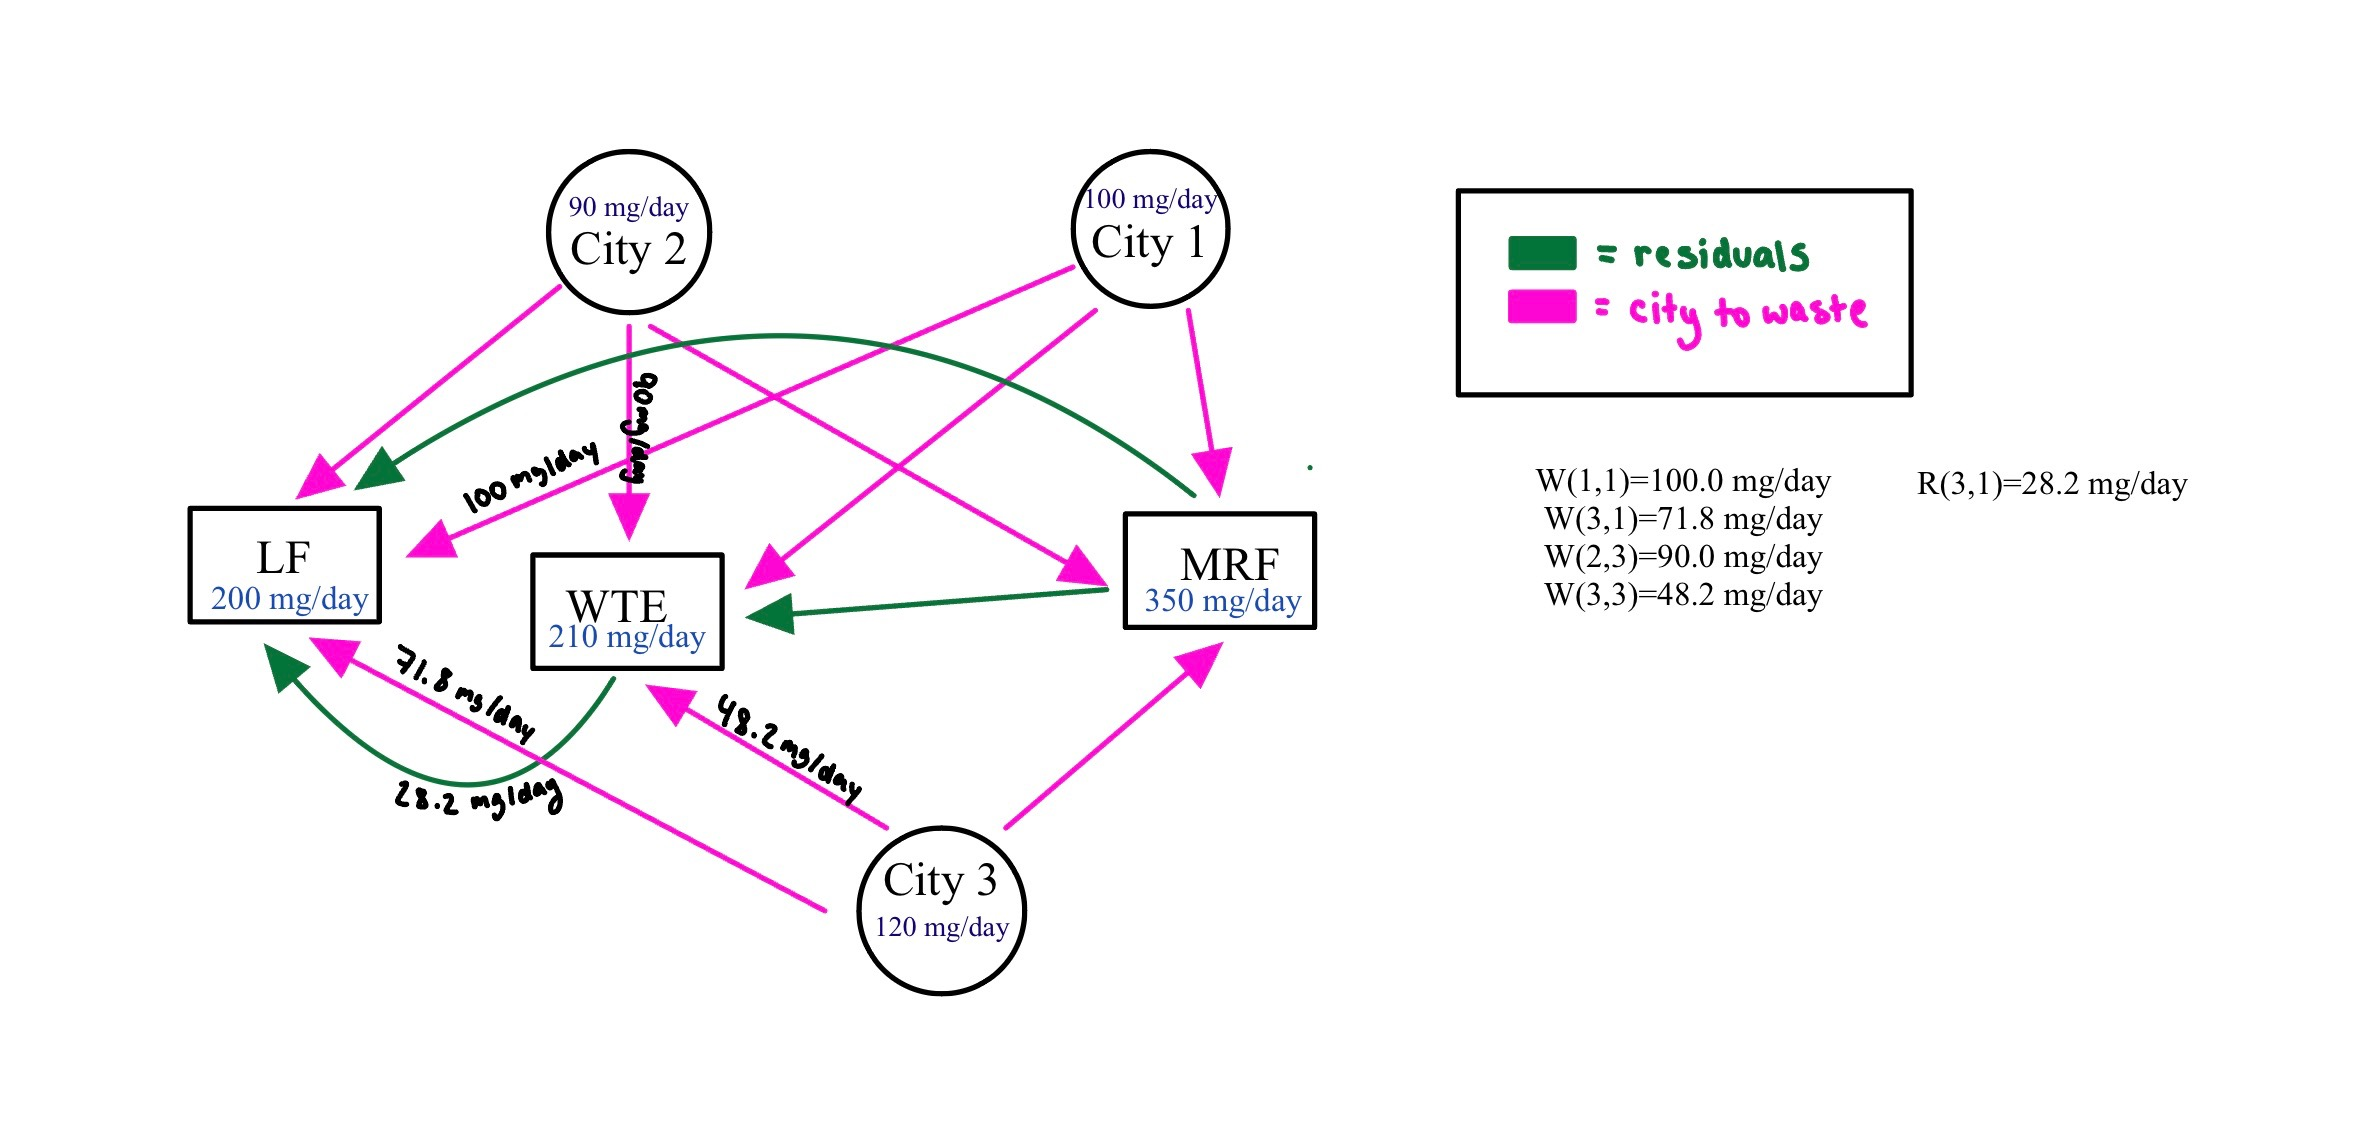

#### Problem 2.4 (5 points)

Would you recommend that the cities build the new landfill? Why or why
not? Your answer should be based on your analysis but can draw on other
considerations as appropriate or desired.

I would not recommend the cities to build a new landfill as the new objective value increased, therefore indicating that it is more expensive to upkeep a new landfill disposal. Furthermore, since the waste distributed stayed the same, there is no benefit in adding a new landfill. 

## References

List any external references consulted, including classmates.

Sinahy Fragoso 

Lindsey Conboy 

Grace Duffy